# はじめに
今までなんとなくStanなどを使ってMCMCをやっていた。
ギブスサンプリングぐらいなら昔勉強したけど、ハミルトニアンモンテカルロや、ましてやNUTSなどは何をやっているのか理解していなかった。
[基礎からのベイズ統計学](https://www.asakura.co.jp/books/isbn/978-4-254-12212-1/)という本を読んで、ハミルトニアンモンテカルロまではなんとなくわかったので、プログラムを書いて理解する。

NUTSはまだわかってないので、
- 独立MH
- ランダムウォークMH
- ハミルトニアンモンテカルロ
を実装する。

理論は[他のブログ](http://qiita.com/hiro5585/items/f50df506b208d37cdd7d)や本を参考にしてほしい。
自分の理解で適当に書いているので、間違ってたらごめんなさい。

# データ
なんでもいいけど、平均3標準偏差1の1次元の正規分布に従うデータから、その平均と分散を推定することにする。

3.02683958884 0.998470831061


/home/kei/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


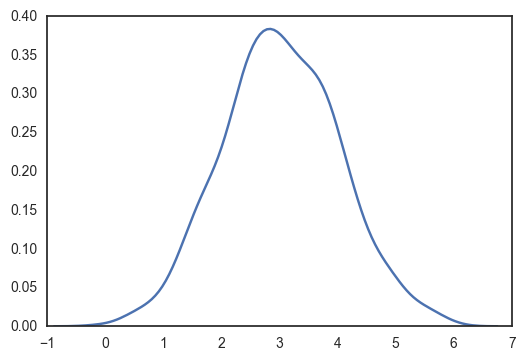

In [19]:
import numpy as np
from numpy import random
from copy import deepcopy
import pylab as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from scipy.stats import norm, gamma
from tqdm import tqdm
sns.set_style("white")

true_μ = 3
true_σ = 1
nb_data = 1000

data = np.random.normal(true_μ, true_σ, nb_data)

print(data.mean(), data.std())

sns.kdeplot(data)
plt.show()

# メトロポリスヘイスティングス法
メトロポリスヘイスティングス法(MH法)では、
1. a \sim q(a|\theta\_t)  からパラメータの候補aを生成する
2. r = \frac{q(\theta\_t | a)f(a)}{q(a|\theta\_t)f(\theta\_t)}
3. 確率 min(1,r)でaを受容し、\theta\_{t+1}=aとする。
を繰り返してパラメータを更新していく。
よって、現在のパラメータから新しいパラメータを生成するときの確率q(a|\theta\_t)、および、尤度fを計算するときの分布の形状(提案分布)を決めると、パラメータを推定することができる。

今回は提案分布を正規分布として、その平均と標準偏差を推定する。

# 独立メトロポリスヘイスティングス法
まずはq(a|\theta\_t) = q(a)、つまり次のパラメータを前のパラメータに依存せず独立にサンプリングする。
今回は平均と標準偏差の推定なので、それぞれ正規分布およびガンマ分布からパラメータをサンプリングする。

In [182]:
sampling_μ_mean = 0
sampling_μ_std = 10
sampling_σ_a = 2

norm_lpdf = lambda x, μ, σ: np.sum(norm.logpdf(x, μ, σ))
gamma_lpdf = lambda x, a: np.sum(gamma.logpdf(x, a))

logf = lambda θₜ: norm_lpdf(data, θₜ["μ"], θₜ["σ"])
logq = lambda θₜ: norm_lpdf(θₜ["μ"], sampling_μ_mean, sampling_μ_std) \
    + gamma_lpdf(θₜ["σ"], sampling_σ_a)
logr = lambda a, θₜ: logq(θₜ) + logf(a) - logq(a) - logf(θₜ)

nb_samples = 1000
θₜ = {}
a = {}  # 候補点

hist = []

θₜ["μ"] = random.normal(sampling_μ_mean, sampling_μ_std)
θₜ["σ"] = random.gamma(sampling_σ_a)

for t in tqdm(range(nb_samples)):
    a["μ"] = random.normal(sampling_μ_mean, sampling_μ_std)
    a["σ"] = random.gamma(sampling_σ_a)

    if logr(a, θₜ) > 0:
        θₜ = deepcopy(a)
        hist.append([a["μ"], a["σ"], 0])
    else:
        if np.exp(logr(a, θₜ)) > random.uniform(0, 1):
            θₜ = deepcopy(a)
            hist.append([a["μ"], a["σ"], 1])
        else:
            hist.append([a["μ"], a["σ"], 2])
hist = np.array(hist)

print(θₜ)

100%|██████████| 1000/1000 [00:02<00:00, 376.54it/s]

{'σ': 1.059452622545741, 'μ': 2.844598864784441}


サンプリングがどのように進んだかをプロットしてみる。
青い点が受容されたパラメータ、赤いバツが棄却された候補を表している。
殆どの候補が棄却されて、むちゃくちゃ効率が悪いことがわかる。

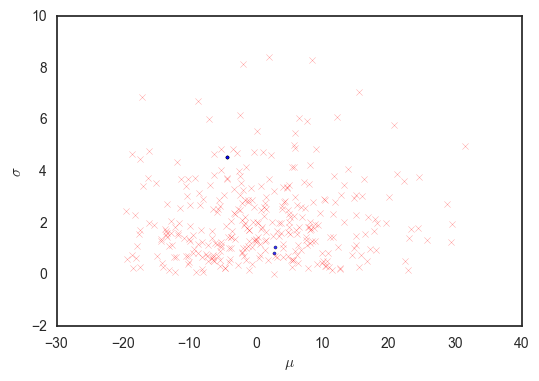

In [183]:
def update(i, hist):
    if hist[i, 2] == 0:
        plt.scatter(hist[i, 0], hist[i, 1], marker=".", c="b", alpha=0.8)
    elif hist[i, 2] == 1:
        plt.scatter(hist[i, 0], hist[i, 1], marker=".", c="g", alpha=0.8)
    elif hist[i, 2] == 2:
        plt.scatter(hist[i, 0], hist[i, 1], marker="x", c="r", alpha=0.4)

fig = plt.figure()
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
ani = FuncAnimation(fig, update, fargs=(hist,), frames=nb_samples//3)
ani.save("independent.gif", writer="imagemagick")


# ランダムウォークMH法
$a = \theta_t + e$として、新しいパラメータ候補aを生成すると、これまで見つかった良さそうなパラメータの周辺を探索することになるので、受容率が上がって効率のいいサンプリングが行える。

今回はeが平均0、標準偏差0.05の正規分布に従うとしてサンプリングを行った。
このとき、q(a|\theta\_t) = \mathcal{N}(\theta\_t|0.05)　になる。
q(\theta\_t|a)も同様。

In [179]:
sampling_mean = 0
sampling_std = 0.05

logf = lambda θₜ: norm_lpdf(data, θₜ["μ"], θₜ["σ"])
logq = lambda a, θₜ: norm_lpdf(θₜ["μ"], sampling_mean+a["μ"], sampling_std) \
    + norm_lpdf(θₜ["σ"], sampling_mean+a["σ"], sampling_std)
logr = lambda a, θₜ: logq(θₜ,a) + logf(a) - logq(θₜ,a) - logf(θₜ)

nb_samples = 1000
θₜ = {}
a = {}  # 候補点

hist = []
hist_2sigma = []
nb_i = 40
sample_2sigma = [np.array([2*sampling_std*np.sin(i*2*np.pi/nb_i), 
                           2*sampling_std*np.cos(i*2*np.pi/nb_i)]) for i in range(nb_i)]

θₜ["μ"] = random.normal(1, 1)
θₜ["σ"] = random.gamma(3)

for t in tqdm(range(nb_samples)):
    a["μ"] = θₜ["μ"] + random.normal(sampling_mean, sampling_std)
    a["σ"] = θₜ["σ"] + random.normal(sampling_mean, sampling_std)

    if logr(a, θₜ) > 0:
        θₜ = deepcopy(a)
        hist.append([a["μ"], a["σ"], 0])
    else:
        if np.exp(logr(a, θₜ)) > random.uniform(0, 1):
            θₜ = deepcopy(a)
            hist.append([a["μ"], a["σ"], 1])
        else:
            hist.append([a["μ"], a["σ"], 2])
            
    hist_2sigma.append([np.array([θₜ["μ"],θₜ["σ"]]) + sample_2sigma_i 
                        for sample_2sigma_i in sample_2sigma])

hist = np.array(hist)
hist_2sigma = np.array(hist_2sigma)
print(θₜ)

100%|██████████| 1000/1000 [00:01<00:00, 592.47it/s]

{'σ': 0.9944398277566455, 'μ': 3.0750991483862506}


In [177]:
def plot(hist, hist_2sigma, filename, T=1):
    lim_range = 0.2
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fill, = ax.fill(hist_2sigma[0, :, 0], hist_2sigma[0, :, 1], alpha=0.2, c="gray")
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\sigma$")

    def update(i, hist, hist_2sigma, line):
        fill.set_xy(hist_2sigma[i])
        fig.canvas.draw()
        
        if hist[i, 2] == 0:
            ax.scatter(hist[i, 0], hist[i, 1], marker=".", c="b", alpha=0.8, linewidths=0)
        elif hist[i, 2] == 1:
            ax.scatter(hist[i, 0], hist[i, 1], marker=".", c="g", alpha=0.8, linewidths=0)
        else:  # hist[i, 2] == 2:
            ax.scatter(hist[i, 0], hist[i, 1], marker="x", c="r", alpha=0.4)
        
        plot_lim = 10
        if i > plot_lim:
            plt.xlim(min(min(hist[i - plot_lim:i, 0]), 3-lim_range), 
                     max(max(hist[i - plot_lim:i, 0]), 3+lim_range))
            plt.ylim(min(min(hist[i - plot_lim:i, 1]), 1-lim_range), 
                     max(max(hist[i - plot_lim:i, 1]), 1+lim_range))

    ani = FuncAnimation(fig, update, fargs=(hist, hist_2sigma, line), frames=nb_samples//T)
    ani.save(filename, writer="imagemagick")

青い点および赤いバツは上と同じ、確率rで受容されたパラメータ。
96%ぐらいのパラメータの候補が灰色の領域から選ばれる。
全部プロットしていると時間がかかりすぎるので、はじめから1/3ぐらいをプロットした。

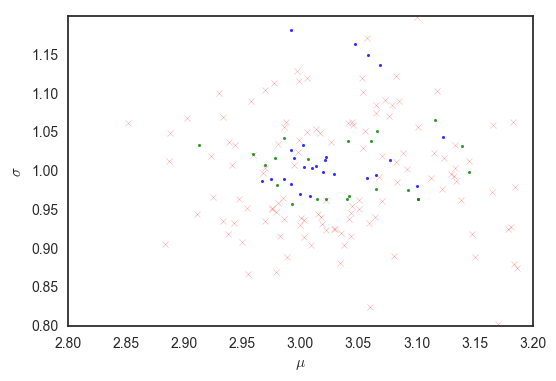

In [180]:
plot(hist, hist_2sigma, "random_walk.gif", 3)

# ハミルトニアンモンテカルロ法
ランダムウォークMH法はeを適切に設定しないとうまくいかない(らしい)。
パラメータによる勾配が利用できるのであれば、それを使ってパラメータを更新すると良さそうである。

ハミルトニアンモンテカルロ法では慣性付きの勾配法っぽい感じでパラメータを更新する。
1. モーメンタムpを標準正規乱数から発生させる。
2. ポテンシャルh(\theta)を対数事後分布として、慣性付きの勾配法を進めて、Lステップ後の値を\theta\_aとする。
3. r = exp(H(\theta\_t, p\_t) - H(\theta\_a, p\_a))を求める。
4. 確率 min(1,r)でパラメータ\theta\_aを受容する。

ここでHはハミルトニアンで
H(\theta, p) = h(\theta) + 1/2 p \cdot p

普通の勾配法と違うのは、
- Lステップ更新するごとに、慣性項を標準正規乱数でリセットする。
- まれに更新を棄却する
- 粘性項がない
といったところか。

(普通の確率勾配法で更新したらいかんのかと思ってしまうけど、そういう研究もあるんだろうな)

In [173]:
def log_dh(x, μ, σ):
    return np.array([-np.sum(x - μ) / σ**2,
                     len(x) / (2 * σ**2) - np.sum((x - μ)**2) / (2 * σ**4)])

def H(x, θₜ, p):
    return -norm_lpdf(x, θₜ["μ"], θₜ["σ"]) + 0.5 * np.dot(p, p)

nb_samples = 1000
θₜ = {}
θₐ = {}

ε = 0.01
L = 100

hist = []
hist_2sigma = []
θₜ["μ"] = random.normal(1, 1)
θₜ["σ"] = random.gamma(3)
nb_i = 40
p_2sigma = [np.array([2*np.sin(i*2*np.pi/nb_i), 
                      2*np.cos(i*2*np.pi/nb_i)]) for i in range(nb_i)]

def update(pₜ, θₜ):
    pₐ = deepcopy(pₜ)
    θₐ = deepcopy(θₜ)
    for t in range(L):
        pₐ -= ε / 2 * log_dh(data, θₐ["μ"], θₐ["σ"])
        dμ, dσ = ε * pₐ
        θₐ["μ"] += dμ
        θₐ["σ"] += dσ
        θₐ["σ"] = np.abs(θₐ["σ"])
        pₐ -= ε / 2 * log_dh(data, θₐ["μ"], θₐ["σ"])    
    return  pₐ, θₐ 

for i in tqdm(range(nb_samples)):
    pₜ = np.random.randn(2)
    pₐ, θₐ = update(pₜ, θₜ)
    if np.exp(H(data, θₜ, pₜ) - H(data, θₐ, pₐ))>1:
        θₜ = deepcopy(θₐ)
        hist.append([θₐ["μ"], θₐ["σ"], 0])
    elif np.exp(H(data, θₜ, pₜ) - H(data, θₐ, pₐ)) > random.uniform(0,1):
        θₜ = deepcopy(θₐ)
        hist.append([θₐ["μ"], θₐ["σ"], 1])
    else:
        hist.append([θₐ["μ"], θₐ["σ"], 2])
    list_θ = [update(p_2sigma_i, θₜ)[1] for p_2sigma_i in p_2sigma]
    hist_2sigma.append(np.array([[θ["μ"],θ["σ"]] for θ in list_θ]))

hist = np.array(hist)
hist_2sigma = np.array(hist_2sigma)
print(θₜ)

100%|██████████| 1000/1000 [05:34<00:00,  2.24it/s]

{'σ': 1.0048874933483771, 'μ': 3.0559467768730531}


プロットは以下。
だいたい今までと同じだけど、灰色の部分はpを発生させるときに96%ぐらいにしているので、勾配法で更新されたあとでこの範囲にサンプリングが収まっているかは保証されないと思う。
matplotlibのfill関数の使い方が間違っていなければ、最初のほうでサンプリングの範囲がぐちゃぐちゃになっている部分があるが、これは関数がぐちゃぐちゃなのか??

ランダムウォークと比べても、棄却されるサンプルが圧倒的に少なく効率的にサンプリングできている。

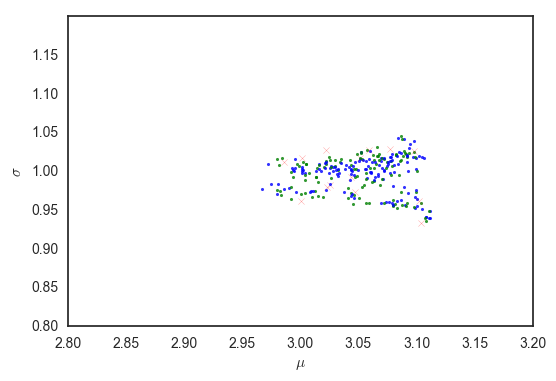

In [174]:
plot(hist, hist_2sigma, "hamiltonian.gif", 3)

# おわりに
自分の勉強のために
- 独立MH
- ランダムウォークMH
- ハミルトニアンモンテカルロ
を実装した。

勾配法との関係がいまいちわかっていなくて、例えばAdamとか使っても詳細釣り合い条件が満たされるのかよくわからない。
次はNUTSを理解したい。